# Load images
https://www.tensorflow.org/tutorials/load_data/images

This tutorial shows how to load and preprocess an image dataset in three ways. 
- First, you will use high-level Keras preprocessing utilities and layers to read a directory of images on disk. 
- Next, you will write your own input pipeline from scratch using tf.data.
- Finally, you will download a dataset from the large catalog available in TensorFlow Datasets.

In [1]:
import numpy as np
import os, PIL
import PIL.Image 
import torch
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.3.0


In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,fname='flower_photos',untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
img_count = len(list(data_dir.glob('*/*.jpg')))
img_count

3670

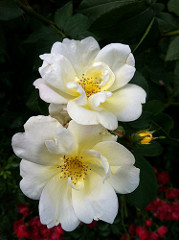

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(roses[0])

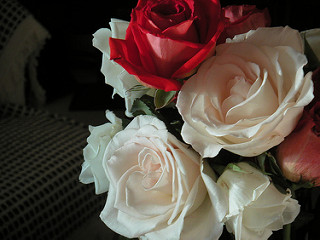

In [5]:
PIL.Image.open(roses[1])

In [6]:
BATCH_SIZE = 64
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                validation_split=0.2,
                                subset='training',
                                seed=21,
                                image_size=(IMG_HEIGHT, IMG_WIDTH),
                                batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                validation_split = 0.2,
                                subset='validation',
                                seed=21,
                                image_size=(IMG_HEIGHT, IMG_WIDTH),
                                batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

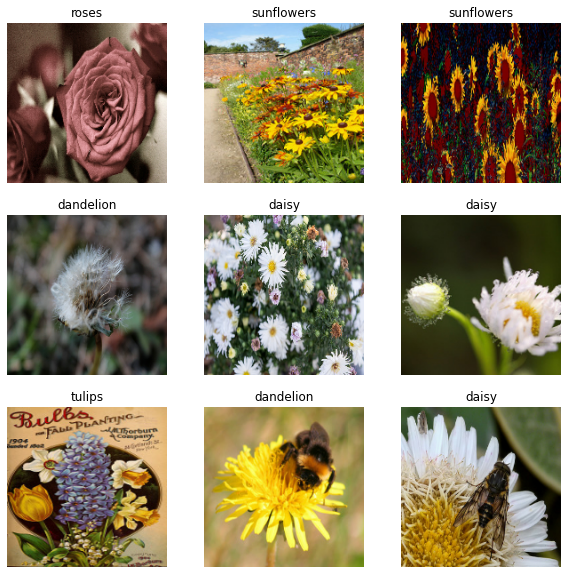

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 180, 180, 3)
(64,)


In [12]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.99847496


In [14]:
# Configure the dataset for performance

# .cache() keeps the images in memory after they're loaded off disk 
# during the first epoch. This will ensure the dataset does not become 
# a bottleneck while training your model. If your dataset is too large 
# to fit into memory, you can also use this method to create a performant 
# on-disk cache.

# .prefetch() overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
46/46 [==============================] - 13s 286ms/step - loss: 1.3698 - accuracy: 0.4022 - val_loss: 1.0908 - val_accuracy: 0.5191
Epoch 2/3
46/46 [==============================] - 2s 36ms/step - loss: 1.0497 - accuracy: 0.5804 - val_loss: 1.0149 - val_accuracy: 0.5736
Epoch 3/3
46/46 [==============================] - 2s 36ms/step - loss: 0.9087 - accuracy: 0.6379 - val_loss: 0.9332 - val_accuracy: 0.6240


In [19]:
# Using tf.data for finer control
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(img_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\rahul\\.keras\\datasets\\flower_photos\\dandelion\\3499837275_5f24d2f8bf_n.jpg'
b'C:\\Users\\rahul\\.keras\\datasets\\flower_photos\\sunflowers\\864957037_c75373d1c5.jpg'
b'C:\\Users\\rahul\\.keras\\datasets\\flower_photos\\sunflowers\\5025805406_033cb03475_n.jpg'
b'C:\\Users\\rahul\\.keras\\datasets\\flower_photos\\tulips\\8892851067_79242a7362_n.jpg'
b'C:\\Users\\rahul\\.keras\\datasets\\flower_photos\\dandelion\\3502447188_ab4a5055ac_m.jpg'


In [25]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [27]:
val_size = int(img_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [32]:
# Write a short function that converts a file path to an (img, label) pair:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


In [33]:
# Use Dataset.map to create a dataset of image, label pairs:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


Image shape:  (180, 180, 3)
Label:  1


In [35]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

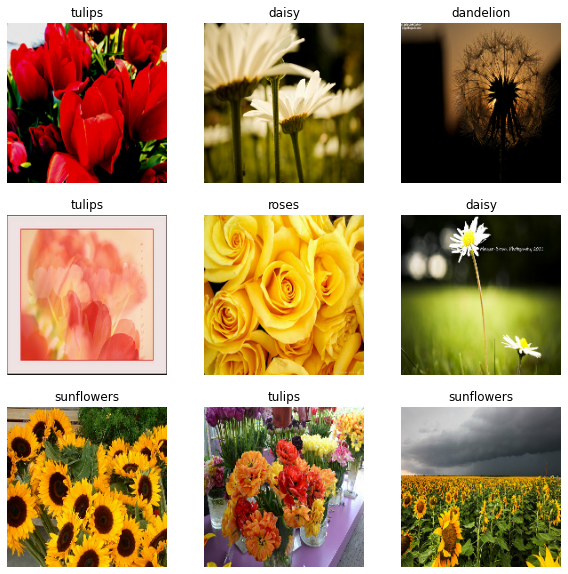

In [36]:
# visualize

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [37]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
46/46 [==============================] - 2s 50ms/step - loss: 0.8542 - accuracy: 0.6686 - val_loss: 0.8095 - val_accuracy: 0.7098
Epoch 2/3
46/46 [==============================] - 2s 39ms/step - loss: 0.7129 - accuracy: 0.7292 - val_loss: 0.8201 - val_accuracy: 0.6975
Epoch 3/3
46/46 [==============================] - 2s 39ms/step - loss: 0.5970 - accuracy: 0.7807 - val_loss: 0.9486 - val_accuracy: 0.6444


In [38]:
# Using TensorFlow Datasets
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to C:\Users\rahul\tensorflow_datasets\tf_flowers\3.0.1.incompleteM05F78\tf_flowers-train.tfrecord


Dataset tf_flowers downloaded and prepared to C:\Users\rahul\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [40]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


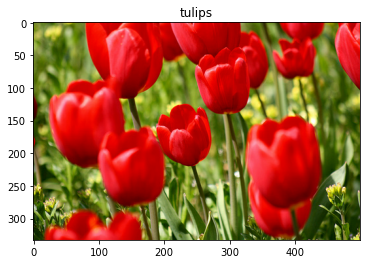

In [39]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))